In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from macro import get_neighbour_sum_matrix_conv, calcEnergy, calcMag, get_neighbour_sum_matrix
import csv
from pathlib import Path

2023-10-16 15:13:23.876043: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 15:13:23.924216: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 15:13:25.075264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Simulation of Ising Model on 2D lattice
This notebook presents the data generated using the Monte Carlo method.<br>


## Metropolis Alghoritm
<strong>In each simulation</strong>:
 
 - A 64x64 lattice was initialzied with random spin configurations.
 - Then, 500 iterations were performed of following alghorithm:<br>
 a) Lattice indices indices were placed in random order<br>
 b) For each spin in the list of indices current energy of the spin and it's fliped version were calculated<br>
 b) It was decided based on the resulting energy difference $\Delta E$ whenever to filp the spin or not: <br>
    if $\Delta E$ < 0 then new spin value was saved<br>
    if $\Delta E$ > 0 then new spin value had probability of $e^{-(\Delta E)/T}$ of being saved<br>
 - The final spin configurations, as well as energy and magnetization for each iteration step, were saved.

In [ ]:
def time_series(folder):
    try:
        folder_path = Path(folder)
        reader = csv.DictReader(open(folder_path / "parameters.csv"))
        par_dict = next(reader) 
    except:
        raise ValueError("Invalid folder provided")

    n_rows = int(par_dict['Simulatiton Number'])

    fig = plt.figure(constrained_layout=True, figsize=(20, 20))
    fig.suptitle(f"Temperature: {par_dict['Temperature']} External Field: {par_dict['Magnetic Field']}", fontsize=18)

    subfigs = fig.subfigures(nrows=n_rows, ncols=1)

    for index, subfig in enumerate(subfigs):
        subfig.suptitle(f'Simulation number: {index}')
        data = np.load(folder_path / f"output{index+1}" / "final.npy")

        axs = subfig.subplots(nrows=1, ncols=3)

        axs[0].imshow(data)
        axs[0].set_title(f'Maze')

        columns = ['iter','energy','mag']
        df = pd.read_csv(folder_path / f"output{index+1}" / "data.csv", header=None, names=columns).set_index('iter')

        axs[1].plot(df.energy)
        axs[1].set_title(f'Energy')

        axs[2].plot(df.mag)
        axs[2].set_title(f'Magnetization')

In [ ]:
time_series("./Rust/get_data_rust/Test")

## Low Temperature
Low equilibrium energy, long time of relaxation

In [ ]:
time_series("Rust/Demo/Low")

## High temperature
Simulation starts not too far from the equilibrium and oscilates vividly

In [ ]:
time_series("Rust/Demo/High")

## Around critical temperature
For 2d lattice with periodic boundary conditions $T_{crit} \approx 2.7$

In [ ]:
time_series("Rust/Demo/Crit")

## Positive Magnetic Field

In [ ]:
time_series("Rust/Demo/MagPositive/")

## Negative Magnetic Field

In [ ]:
time_series("Rust/Demo/MagNegative/")

## New Simulate Function

Implementation based on numpy matrix operations

In [ ]:
def iterate(m, T, H):
    m_sum = get_neighbour_sum_matrix(m)
    e_diff = - (m_sum + H) * ( -2 * m)
    spin_flip_mask = np.random.rand(*m.shape)<np.where(e_diff>0,np.exp(-e_diff/T), 1.0) 
    m = m + m*(-2)*spin_flip_mask
    return m

def get_maze(N = 64):
    m = 2 * np.random.randint(0,2,(N,N)) -1
    return m

def simulate(n, T, H):
    m = get_maze()
    energies = []
    magnetizations = []
    for _ in range(n):
        m = iterate(m, T, H)
        energies.append(calcEnergy(m))
        magnetizations.append(calcMag(m))
    return energies, magnetizations, m


In [ ]:
def simulate_with_plot(num, simulate, steps = 500, h = 0):
    n_rows = num

    fig = plt.figure(constrained_layout=True, figsize=(20, 20))
    subfigs = fig.subfigures(nrows=n_rows, ncols=1)

    for index, subfig in enumerate(subfigs):
        random_temperature = 2.9
        energies, magnetization, mat = simulate(steps, random_temperature, h)
        subfig.suptitle(f'Nr: {index} Temperature: {random_temperature:.2f}')

        axs = subfig.subplots(nrows=1, ncols=3)

        axs[0].imshow(mat)
        axs[0].set_title(f'Maze')

        axs[1].plot(energies)
        axs[1].set_title(f'Energy')

        axs[2].plot(magnetization)
        axs[2].set_title(f'Magnetization')

In [ ]:
simulate_with_plot(100, simulate)

## Wolff

Flipping clusters of spins

In [ ]:
def flipCluster(mat,cluster):
    # Flip all spins in a cluster. Used for the Wolff algorithm.
    """
    Parameters:
        mat: numpy array containing the current spin configuration
        cluster: List of spins to be flipped 
    """
    for pair in cluster:
        i,j=pair
        mat[i,j]*=-1
        
def iterateWolff(mat,T):
    # Wolff algorithm
    """
    Parameters:
        mat: numpy array containing the current spin configuration
        T: Temperature for the simulation
    """
    L,_ = mat.shape
    tracker = np.zeros((L,L))
    
    i,j = np.random.randint(0,L,size=2)
    spin = mat[i,j]
    stack = [(i,j)]
    tracker[i,j]=1
    
    cluster = [(i,j)]
    while len(stack)>0:
        i,j = stack.pop()
        neighbors = [(i,(j+1)%L),(i,(j-1)%L),((i+1)%L,j),((i-1)%L,j),((i+1)%L,(j+1)%L),((i-1)%L,(j-1)%L)]
        for pair in neighbors:
            l,m = pair
            if (mat[l,m]==spin and tracker[l,m]==0 and np.random.random()< (1.0-np.exp(-2.0/T))):
                cluster.append((l,m))
                stack.append((l,m))
                tracker[l,m]=1
            
    flipCluster(mat,cluster)

def simulateWolff(n, T, H):
    mat = get_maze()
    energies = []
    magnetizations = []
    for step in range(n):
        iterateWolff(mat, T)
        energies.append(calcEnergy(mat))
        magnetizations.append(calcMag(mat))
    return  energies, magnetizations, mat

In [ ]:
simulate_with_plot(5, simulateWolff)

## Convolutional Layer

Test made for convolutional implementation of function which calculates sum of neighbouring cells. 

In [ ]:
ones = np.ones((10, 10))
results = get_neighbour_sum_matrix_conv(ones)
sns.heatmap(results)

# Energy and magnetisation distributions

I have stopped here because I've came across a problem with the simulations using the metropolis algorithm.<br>
Simulations do not thermalize and performing more steps doesnt really helps

In [2]:
def get_data_from_folder(folder):
    try:
        folder_path = Path(folder)
        reader = csv.DictReader(open(folder_path / "parameters.csv"))
        par_dict = next(reader) 
    except:
        raise ValueError("Invalid folder provided")
    print(par_dict)

    folders = [f"{folder}/output{i}/final.npy" for i in range(1, int(par_dict['Simulatiton Number']) + 1)]
    df = pd.DataFrame(folders, columns =['folder'])
    df['data'] = df['folder'].apply(lambda x: np.load(x))
    df['Magnetization'] = df['data'].apply(calcMag)
    df['Energy'] = df['data'].apply(calcEnergy)
    df['Steps'] = int(par_dict['Steps'])
    return df.drop(columns=['data'])

df_15 = get_data_from_folder('./Rust/get_data_rust/Data/Crit/')
df_10 = get_data_from_folder('./Rust/get_data_rust/Data/Crit1000/')
df_20 = get_data_from_folder('./Rust/get_data_rust/Data/Crit2000/')
df_wolff = get_data_from_folder('./Rust/get_data_rust/Data/Wolff')

{'Steps': '1500', 'Simulatiton Number': '1000', 'Temperature': '2.73', 'Magnetic Field': '0', 'Mattize Size': '64'}
{'Steps': '1000', 'Simulatiton Number': '1000', 'Temperature': '2.73', 'Magnetic Field': '0', 'Mattize Size': '64'}
{'Steps': '2000', 'Simulatiton Number': '1000', 'Temperature': '2.73', 'Magnetic Field': '0', 'Mattize Size': '64'}
{'Steps': '1000', 'Simulatiton Number': '1000', 'Temperature': '2.73', 'Magnetic Field': '0', 'Mattize Size': '64'}


In [3]:
df_metro = pd.concat([df_10, df_15, df_20])

In [4]:
df_10['algorithm'] = 'Metropolis'
df_wolff['algorithm'] = 'Wolff'
df_alogrithm = pd.concat([df_10, df_wolff])

/home/hombre/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_4838/628397742.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/home/hombre/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_4838/628397742.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


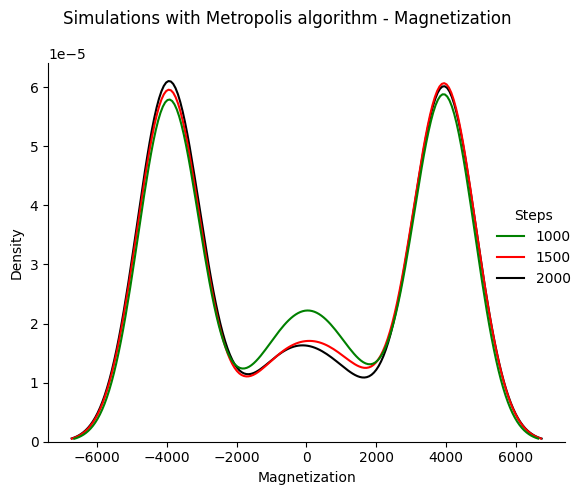

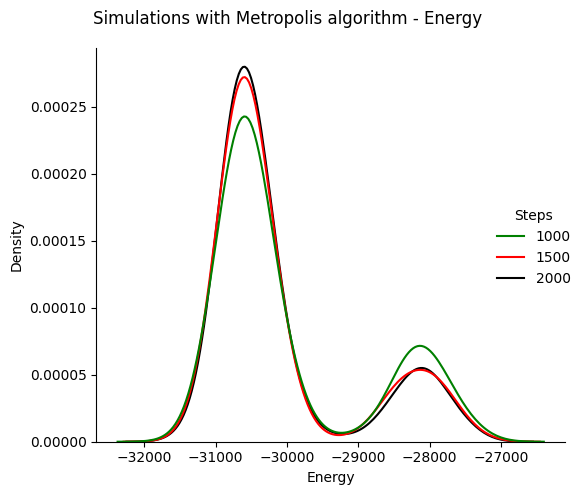

In [5]:
sns.displot(
    data=df_metro,
    x="Magnetization", hue="Steps", kind="kde",palette=['green', 'red', 'black']
)
plt.suptitle("Simulations with Metropolis algorithm - Magnetization")
plt.tight_layout()
sns.displot(
    data=df_metro,
    x="Energy", hue="Steps", kind="kde",palette=['green', 'red', 'black']
)
plt.suptitle("Simulations with Metropolis algorithm - Energy")
plt.tight_layout()

<strong>Wolff algorithm</strong> is said to be more efficient at critical temperatures and it indeed thermalized as it is shown below

/home/hombre/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/hombre/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Comparing two algorithm - Energy')

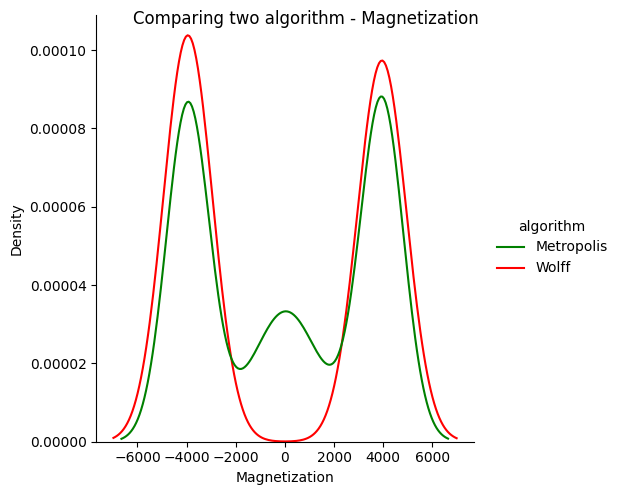

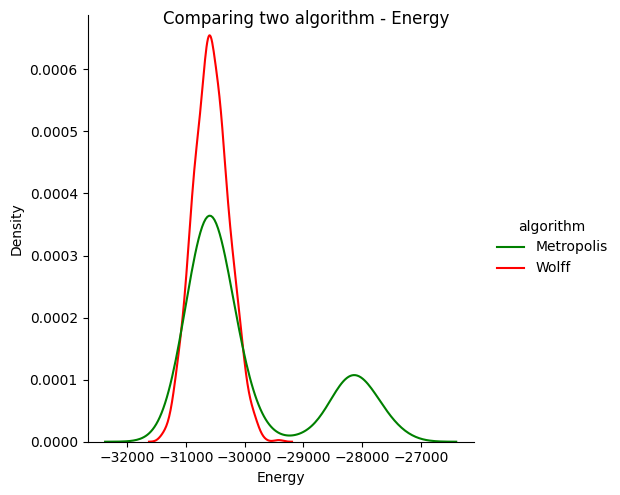

In [11]:
sns.displot(
    data=df_alogrithm,
    x="Magnetization", hue="algorithm", kind="kde", palette=['green', 'red']
)
plt.suptitle("Comparing two algorithms - Magnetization")
sns.displot(
    data=df_alogrithm,
    x="Energy", hue="algorithm", kind="kde",palette=['green', 'red']
)
plt.suptitle("Comparing two algorithms - Energy")